# Consumer Water Consumption

In [1]:
# Import system Module
#import sys
# Append Code Sharing to SYS path
#sys.path.insert(0, r"\\UUG.VCM.CC\Wholesale\Insight_and_Analytics\Code Sharing")
# Import connection functions (homemade functions to connect to databases etc)
#import uu_connection_functions as uudcf
#df = uudcf.df_from_odbc(dsn="Prod", sql_que ry="select dbo.DEMAND_MONITORING_ZONE_NAME, fbo.DAILY_CONSUMPTION, dda.CAL_DATE from PRJ_APPRENTICE.EXV_TRNS_LAYER_TBL_D_BOUNDARY as dbo left join PRJ_APPRENTICE.EXV_TRNS_LAYER_TBL_F_BOUNDARY_DEMAND as fbo on dbo.BOUNDARY_SK = fbo.BOUNDARY_SK left join PRJ_APPRENTICE.EXV_TRNS_LAYER_TBL_D_DATE as dda on fbo.DATE_SK = dda.DATE_SK where fbo.FORECAST_FLAG = 'N' and dbo.DEMAND_MONITORING_ZONE_NAME = 'Kendal';")

# Import system Module
import sys
# Append Code Sharing to SYS path
sys.path.insert(0, r"\\UUG.VCM.CC\Wholesale\Insight_and_Analytics\Code Sharing")
# Import connection functions (homemade functions to connect to databases etc)
import uu_connection_functions as uudcf
df = uudcf.df_from_odbc(dsn="Prod", sql_query="select dbo.DEMAND_MONITORING_ZONE_NAME, fbo.DAILY_CONSUMPTION, dda.CAL_DATE from PRJ_APPRENTICE.EXV_TRNS_LAYER_TBL_D_BOUNDARY as dbo left join PRJ_APPRENTICE.EXV_TRNS_LAYER_TBL_F_BOUNDARY_DEMAND as fbo on dbo.BOUNDARY_SK = fbo.BOUNDARY_SK left join PRJ_APPRENTICE.EXV_TRNS_LAYER_TBL_D_DATE as dda on fbo.DATE_SK = dda.DATE_SK where fbo.FORECAST_FLAG = 'N' and dbo.DEMAND_MONITORING_ZONE_NAME = 'Kendal';")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import scipy.stats
from scipy.stats.distributions import chi2
import pylab
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Data Cleaning and Preparation 

In [2]:
# Convert date to Datetime and set as index
df.CAL_DATE = pd.to_datetime(df.CAL_DATE)
df = df.sort_values(by='CAL_DATE')
df.set_index('CAL_DATE', inplace=True)

# Checking for null values in the DataFrame
null_values = df.isna().sum().sort_values(ascending=False)
print("Null values in DataFrame:", null_values)

# Aggregate consumption values to one value per day if there are multiple records per day
df_daily = df.groupby(df.index).agg({'DAILY_CONSUMPTION': 'sum'})

# Set frequency to daily and check info
df_daily = df_daily.asfreq('D')  
print("DataFrame information with daily frequency set:")
df_daily.info()

Null values in DataFrame: DEMAND_MONITORING_ZONE_NAME    0
DAILY_CONSUMPTION              0
dtype: int64
DataFrame information with daily frequency set:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3061 entries, 2016-04-01 to 2024-08-17
Freq: D
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DAILY_CONSUMPTION  3061 non-null   float64
dtypes: float64(1)
memory usage: 47.8 KB


# EDA - Exploratory Data Analysis

In [3]:
#Visualise the daily data
print(df_daily.head(10))
print(df_daily.tail(10))

            DAILY_CONSUMPTION
CAL_DATE                     
2016-04-01         303941.824
2016-04-02         303177.241
2016-04-03         303174.936
2016-04-04         294551.509
2016-04-05         295023.300
2016-04-06         295229.709
2016-04-07         295319.233
2016-04-08         295959.335
2016-04-09         298107.918
2016-04-10         298405.395
            DAILY_CONSUMPTION
CAL_DATE                     
2024-08-08         353087.046
2024-08-09         353087.046
2024-08-10         353087.046
2024-08-11         353087.046
2024-08-12         353087.046
2024-08-13         353087.046
2024-08-14         353087.046
2024-08-15         353087.046
2024-08-16         353087.046
2024-08-17         353087.046


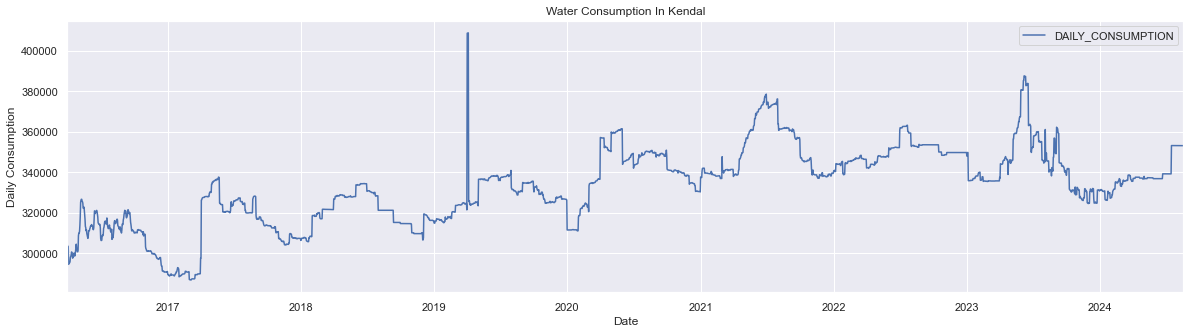

In [4]:
#Plotting the data to visualise
df_daily.plot(figsize = (20,5), title = "Water Consumption In Kendal")
plt.xlabel('Date')
plt.ylabel('Daily Consumption')
plt.legend()
plt.show()

## Anomoly Detection -  Identifying Outliers

In [5]:
#Calculate mean and standard deviation
mean = df_daily['DAILY_CONSUMPTION'].mean()
std = df_daily['DAILY_CONSUMPTION'].std()

In [6]:
#Define outlier cutoff
cutoff = 3
lower_bound = mean - cutoff * std
upper_bound = mean + cutoff * std

In [7]:
#Show outliers - checking that the outliers are correct
df_outliers = df_daily[(df_daily['DAILY_CONSUMPTION'] < lower_bound) | (df_daily['DAILY_CONSUMPTION'] > upper_bound)]
print(df_outliers)

            DAILY_CONSUMPTION
CAL_DATE                     
2019-04-02         408524.952
2019-04-03         408600.679
2019-04-04         408664.212
2019-04-05         408725.581


In [8]:
# Mark outliers as NaN
df_daily.loc[df_daily['DAILY_CONSUMPTION'] < lower_bound, 'DAILY_CONSUMPTION'] = pd.NA
df_daily.loc[df_daily['DAILY_CONSUMPTION'] > upper_bound, 'DAILY_CONSUMPTION'] = pd.NA

# Check which values are marked as NaN
print("Values marked as NaN for interpolation:")
print(df_daily.loc['2019-04-01':'2019-04-28', 'DAILY_CONSUMPTION'])

Values marked as NaN for interpolation:
CAL_DATE
2019-04-01    321401.405
2019-04-02          <NA>
2019-04-03          <NA>
2019-04-04          <NA>
2019-04-05          <NA>
2019-04-06    325546.965
2019-04-07    325873.615
2019-04-08    325882.032
2019-04-09    323987.684
2019-04-10    323982.753
2019-04-11    324145.843
2019-04-12     323675.67
2019-04-13    324226.363
2019-04-14    324236.394
2019-04-15    324248.025
2019-04-16    324188.699
2019-04-17    324208.622
2019-04-18    324273.322
2019-04-19    324667.884
2019-04-20    324672.828
2019-04-21    324685.333
2019-04-22    324683.159
2019-04-23    324677.833
2019-04-24    325161.246
2019-04-25     325393.22
2019-04-26    325304.345
2019-04-27    325285.074
2019-04-28    325282.978
Freq: D, Name: DAILY_CONSUMPTION, dtype: object


In [9]:
# Apply forward fill followed by backward fill if forward fill leaves NaNs
df_daily['DAILY_CONSUMPTION'].fillna(method='pad', inplace=True)

# Verify the interpolation
print("Interpolated values in April 2019 after forward and backward fill:")
print(df_daily.loc['2019-04-01':'2019-04-28', 'DAILY_CONSUMPTION'])

Interpolated values in April 2019 after forward and backward fill:
CAL_DATE
2019-04-01    321401.405
2019-04-02    321401.405
2019-04-03    321401.405
2019-04-04    321401.405
2019-04-05    321401.405
2019-04-06    325546.965
2019-04-07    325873.615
2019-04-08    325882.032
2019-04-09    323987.684
2019-04-10    323982.753
2019-04-11    324145.843
2019-04-12    323675.670
2019-04-13    324226.363
2019-04-14    324236.394
2019-04-15    324248.025
2019-04-16    324188.699
2019-04-17    324208.622
2019-04-18    324273.322
2019-04-19    324667.884
2019-04-20    324672.828
2019-04-21    324685.333
2019-04-22    324683.159
2019-04-23    324677.833
2019-04-24    325161.246
2019-04-25    325393.220
2019-04-26    325304.345
2019-04-27    325285.074
2019-04-28    325282.978
Freq: D, Name: DAILY_CONSUMPTION, dtype: float64


Outliers have been successfuly interpolated using pad methodology, this forward fills all Nan values. This is not a problem for the data as it is a regular occurance for short term flatlining from the flow sensor signals currently. Data intergrity is upheld by using realistic data from a previous expected true value.

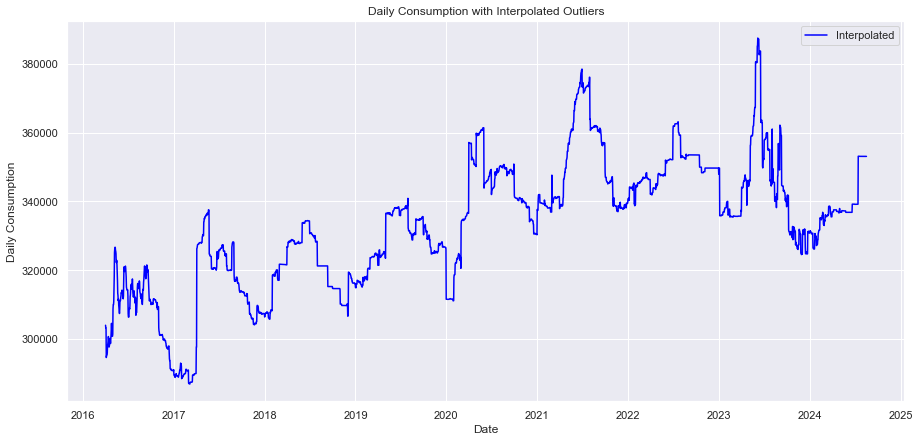

In [10]:
# Plot the interpolated data
plt.figure(figsize=(15, 7))
plt.plot(df_daily.index, df_daily['DAILY_CONSUMPTION'], label='Interpolated', color='blue')
plt.title('Daily Consumption with Interpolated Outliers')
plt.xlabel('Date')
plt.ylabel('Daily Consumption')
plt.legend()
plt.show()

In [11]:
# Create monthly data from daily data
df_monthly = df_daily['DAILY_CONSUMPTION'].resample('M').sum()

# Visualize monthly data
print("Monthly Total Consumption:")
print(df_monthly.head())

Monthly Total Consumption:
CAL_DATE
2016-04-30    8989698.080
2016-05-31    9801102.091
2016-06-30    9473354.169
2016-07-31    9671521.799
2016-08-31    9696525.030
Freq: M, Name: DAILY_CONSUMPTION, dtype: float64


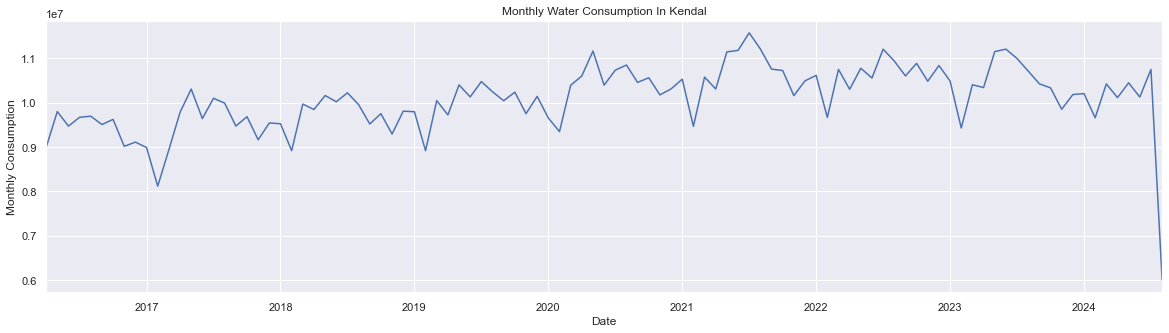

In [12]:
#Plotting the data to visualise
df_monthly.plot(figsize = (20,5), title = "Monthly Water Consumption In Kendal")
plt.xlabel('Date')
plt.ylabel('Monthly Consumption')
plt.show()

Visual assessment of monthly data shows signs of seasonality with an upward trend. There seems signs of an outlier at the end of 2024. This may be due to time of print is mid month and a full set of data hasnt yet been populated.

In [13]:
#Calculate mean and standard deviation
mean = df_monthly.mean()
std = df_monthly.std()

In [14]:
#Define outlier cutoff
cutoff = 3
lower_bound = mean - cutoff * std
upper_bound = mean + cutoff * std

In [15]:
#Show outliers - checking that the outliers removed are correct
df_outliers = df_monthly[(df_monthly < lower_bound) | (df_monthly > upper_bound)]
print(df_outliers)

CAL_DATE
2024-08-31    6002479.782
Freq: M, Name: DAILY_CONSUMPTION, dtype: float64


This value is not an outlier as it is the current month at local time.
The value is low due to being an incomplete month. 
For the purposes of this study, it shall be removed as it is an incomplete data point.

In [16]:
# Remove outliers from the DataFrame
df_monthly = df_monthly[(df_monthly >= lower_bound) & (df_monthly <= upper_bound)]

<AxesSubplot:title={'center':'Monthly Water Consumption In Kendal'}, xlabel='CAL_DATE'>

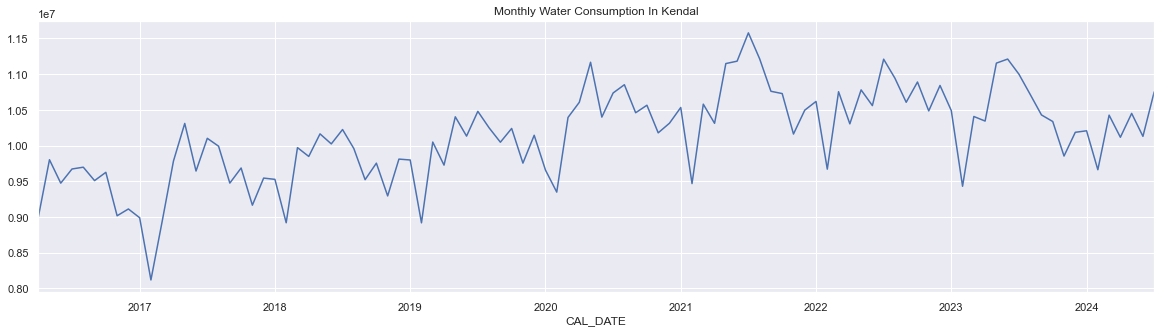

In [17]:
#Plotting the data to visualise
df_monthly.plot(figsize = (20,5), title = "Monthly Water Consumption In Kendal")

## The QQ Plot - Quantile-Quantile Plot

((array([-2.46203784, -2.12570747, -1.93122778, -1.79044653, -1.67819304,
         -1.58381122, -1.50174123, -1.42869743, -1.36256869, -1.30191411,
         -1.24570419, -1.19317644, -1.14374949, -1.09696931, -1.05247413,
         -1.00997067, -0.96921765, -0.93001393, -0.89218993, -0.85560121,
         -0.82012357, -0.78564937, -0.75208458, -0.71934648, -0.68736185,
         -0.65606548, -0.62539893, -0.59530962, -0.56574992, -0.53667655,
         -0.50804994, -0.47983378, -0.45199463, -0.42450149, -0.39732558,
         -0.37044003, -0.34381966, -0.31744076, -0.29128096, -0.26531902,
         -0.23953472, -0.21390872, -0.18842244, -0.16305799, -0.13779803,
         -0.1126257 , -0.08752455, -0.06247843, -0.03747145, -0.01248789,
          0.01248789,  0.03747145,  0.06247843,  0.08752455,  0.1126257 ,
          0.13779803,  0.16305799,  0.18842244,  0.21390872,  0.23953472,
          0.26531902,  0.29128096,  0.31744076,  0.34381966,  0.37044003,
          0.39732558,  0.42450149,  0.

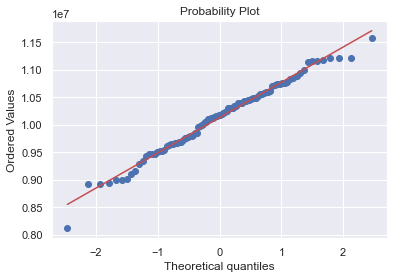

In [18]:
# Instigate QQ plot Should follow the 45-degree line if residuals are normally distributed.
scipy.stats.probplot(df_monthly, plot = pylab)

The QQ Plot statistically visualises the normality of data by arranging in order. A straight line indicates distribution expected in normalised data. Time series data is usually expected to have tails present.

This QQ plot has light tails, showing deviations from the quantile at either end of the data set. This suggests that the extreme values at either end of the data set have a low probability of occuring. 

Moore, D. S., McCabe, G. P., & Craig, B. A. (2021). Introduction to the Practice of Statistics (10th ed.). W. H. Freeman and Company.

# Seasonality and Trend Analysis

## Time Series Decomposition 

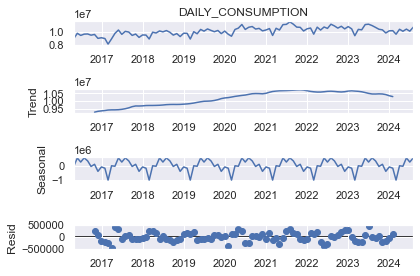

In [19]:
# Decompose the series by seperating out trend, seasonality and residuals
s_dec_additive = seasonal_decompose(df_monthly, model = "additive", period=12)
s_dec_additive.plot()
plt.show()

The Time Series data has been seperated into Trend, Seasonal and showing the residuals.
An upward trend is present overtime which is correct as consumption of water has increased. 
The plot shows that there is a regular pattern pertaining that seasonality may be present.

## Stationarity Check

Stationarity in a Time series pertain to statistical properties remaining static over time. 

If seasonality is present it will either be weak or strict stationarity. 

The Augmented Dickey-Fuller test determines stationarity in a data set.

Null Hypothesis (H0): The time series is non-stationary (contains a unit root).

Alternative Hypothesis (H1): The time series is stationary (does not contain a unit root).

In [20]:
# Perform Dickey-Fuller test 

adfuller = sts.adfuller(df_monthly)

print('ADF Statistic:', adfuller[0])
print('p-value:', adfuller[1])
print('No of Lags:', adfuller[2])
print('No of Observations:', adfuller[3])
for key, value in adfuller[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic: -1.8241091063329151
p-value: 0.36855957619420077
No of Lags: 12
No of Observations: 87
Critical Value (1%): -3.5078527246648834
Critical Value (5%): -2.895382030636155
Critical Value (10%): -2.584823877658872


In [21]:
# Interpret the result

if adfuller[1] < 0.05:
    print("Reject the null hypothesis - the differenced series is likely stationary.")
else:
    print("Fail to reject the null hypothesis - the differenced series is likely non-stationary.")

Fail to reject the null hypothesis - the differenced series is likely non-stationary.


## Autocorrelation Function (ACF)

Data must be stationary to apply models. ACF measures and visualises how the current value is related to the past values. I chose to examine 36 lags, representing 3 years of data.

Slow Decline: Suggests non-stationarity; consider differencing the data.
Sharp Drop: Suggests stationarity; the data is ready for modeling, or a simple AR model may be appropriate.

<function matplotlib.pyplot.show(close=None, block=None)>

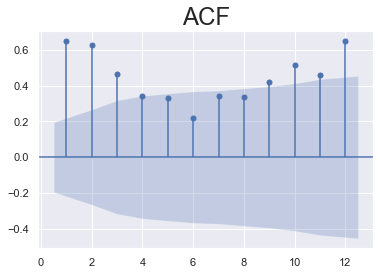

In [22]:
#Autocorrelation presenting the relationship between Time Series Data point and how closely it resembles a prior value.
sgt.plot_acf(df_monthly, lags = 12, zero = False)
plt.title('ACF', size = 24)
plt.show

ACF has shown a slow decline in the relationships between lags, this suggests that the data has a present trend. 
All lags are significant and above the blue line suggesting that there is significant serial correlation. Each point is highly dependant on the last

Stationarity is rarely observed in nature. 

The ACF test has statistically shown that there is no stationarity present, 
as expected due to the trend of water consumption in Kendal rising through the years.

## Difference the Time Series Data


As the time series data exhibits a persistant increasing trend over time the next step is to difference the TSD. 
Differencing helps to remove the trend by subtracting the previous value from the current value.
This will stabalise the mean of the series, preparing the data for a model that requires stationarity. 

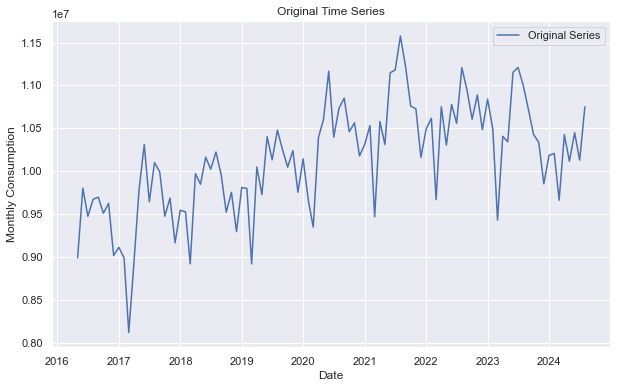

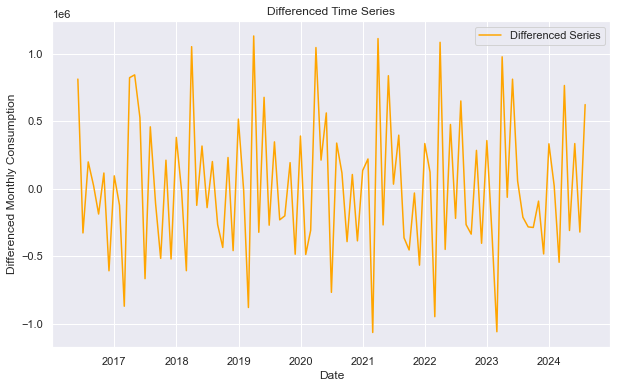

ADF Statistic (Differenced): -4.321721058539409
p-value (Differenced): 0.00040727322994544245
No of Lags (Differenced): 12
No of Observations (Differenced): 86
Critical Values (Differenced):
   1%: -3.5087828609430614
   5%: -2.895783561573195
   10%: -2.5850381719848565
Reject the null hypothesis - the differenced series is likely stationary.


In [23]:
# Plot the original series
plt.figure(figsize=(10, 6))
plt.plot(df_monthly, label='Original Series')
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Monthly Consumption')
plt.legend()
plt.show()

# Differencing the series
df_diff = df_monthly.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10, 6))
plt.plot(df_diff, label='Differenced Series', color='orange')
plt.title('Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Monthly Consumption')
plt.legend()
plt.show()

# Perform ADF test on differenced series
result_diff = sts.adfuller(df_diff)

# Print the results for the differenced series
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])
print('No of Lags (Differenced):', result_diff[2])
print('No of Observations (Differenced):', result_diff[3])
print('Critical Values (Differenced):')
for key, value in result_diff[4].items():
    print(f'   {key}: {value}')

# Interpretation
if result_diff[1] <= 0.05:
    print("Reject the null hypothesis - the differenced series is likely stationary.")
else:
    print("Fail to reject the null hypothesis - the differenced series is likely non-stationary.")


This indicates we reject the null hypothesis of non-stationarity. The p-value of approximately 8.92×10−16 is very low, reinforcing this conclusion. 

The differenced series is likely stationary, with consistent statistical properties over time.

Visual inspections of the Original and Differenced Time Series pertain that the upward trend has been removed. 

<function matplotlib.pyplot.show(close=None, block=None)>

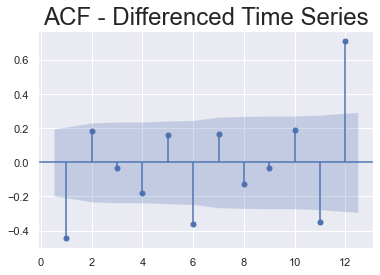

In [24]:
#Autocorrelation presenting the relationship between Time Series Data point and how closely it resembles a prior value.
sgt.plot_acf(df_diff, lags = 12, zero = False)
plt.title('ACF - Differenced Time Series', size = 24)
plt.show

The differenced data now shows a lag spike at the first lag followed by small intervals afterwards. This visualisation suggests that lag 1 would be most suitable to use in model selection.

Experimentation with an ARIMA(1,1,0) or ARIMA(0,1,1) will be carried out 

# Partial Autocorrelation Function (PACF) 

PACT show the difference between the previous value but removes smaller differences between lags. PACF will aid decision making in (AR) component.

<function matplotlib.pyplot.show(close=None, block=None)>

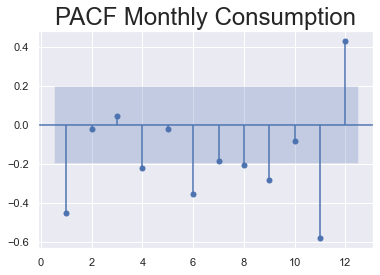

In [25]:
sgt.plot_pacf(df_diff, lags = 12, zero = False, method = ('ols'))
plt.title('PACF Monthly Consumption', size = 24)
plt.show

There is a significant spike present at lag 12, which suggests an annual seasonality may be persistant. 

lag 1 - 11 are less significant due to being close to the confidence interval (blue shaded area)

Due to the strong seasonality presence, the ACF and PACF indicate taht a SARIMA model would be a good use case.

Experimentation start with SARIMA(0,1,1)(1,1,0)[12] is suggestable. 

## Splitting the Data into Train and Test Sections

Preparing the data for modelling by splitting the data in an 80/20 split. The 20% test data wil be used later for validating the model effectivity.

Shuffling and randomising data is not appropriate for time series due to the linearity of Time based data.

In [26]:
# Calculate the index for splitting the dataset at 80% of its length
split_index = int(len(df_diff) * 0.8)

# Split the dataframe into training and testing sets
df_train = df_diff.iloc[:split_index]
df_test = df_diff.iloc[split_index:]

# Print the last few records of the training set and the first few records of the test set
print("First entries in training set:\n", df_train.head())
print("Last entries in training set:\n", df_train.tail())

print("\nFirst entries in test set:\n", df_test.head())
print("\nLast entries in test set:\n", df_test.tail())

First entries in training set:
 CAL_DATE
2016-05-31    811404.011
2016-06-30   -327747.922
2016-07-31    198167.630
2016-08-31     25003.231
2016-09-30   -187790.591
Freq: M, Name: DAILY_CONSUMPTION, dtype: float64
Last entries in training set:
 CAL_DATE
2022-07-31    649498.545
2022-08-31   -266198.286
2022-09-30   -336578.085
2022-10-31    283632.291
2022-11-30   -404479.384
Freq: M, Name: DAILY_CONSUMPTION, dtype: float64

First entries in test set:
 CAL_DATE
2022-12-31     356044.892
2023-01-31    -351259.699
2023-02-28   -1059359.983
2023-03-31     976383.454
2023-04-30     -63901.949
Freq: M, Name: DAILY_CONSUMPTION, dtype: float64

Last entries in test set:
 CAL_DATE
2024-03-31    764080.711
2024-04-30   -309673.542
2024-05-31    334018.740
2024-06-30   -321278.854
2024-07-31    622655.454
Freq: M, Name: DAILY_CONSUMPTION, dtype: float64


# The Seasonal AutoRegressive Integrated Moving Average Model (SARIMA)

## Determining the SARIMA Parameters

In [27]:
# Fit SARIMA model
model = SARIMAX(df_train, order=(0,1,1), seasonal_order=(1,1,0,12))
results = model.fit()

# Display the summary of the model fit
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                   DAILY_CONSUMPTION   No. Observations:                   79
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -927.564
Date:                             Fri, 23 Aug 2024   AIC                           1861.127
Time:                                     13:38:42   BIC                           1867.696
Sample:                                 05-31-2016   HQIC                          1863.723
                                      - 11-30-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9821      0.280     -3.506      0.000      -1.531      -0.433
ar.S.L12      -0.3438      

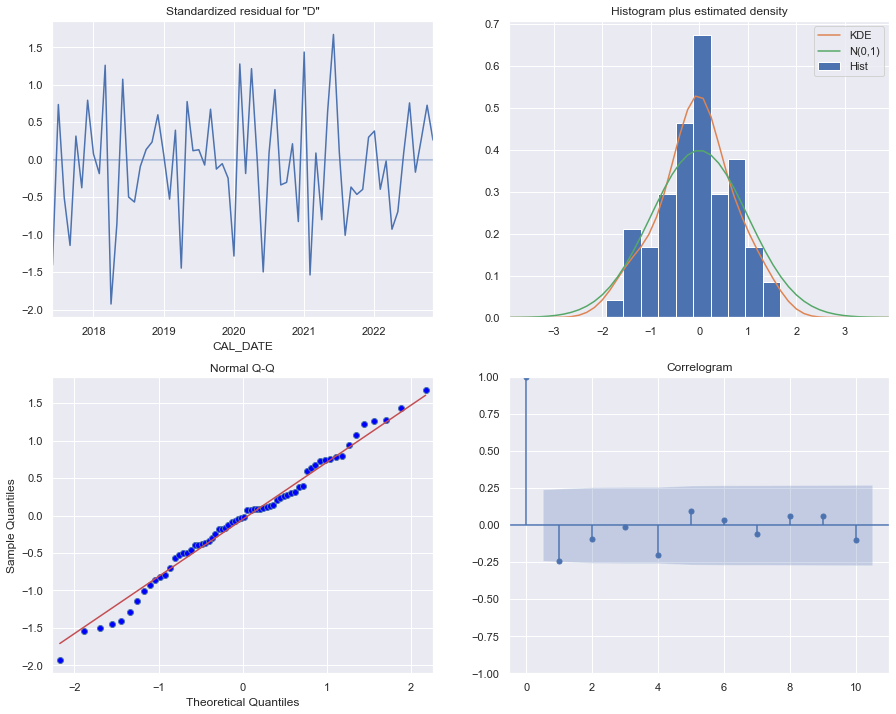

In [28]:
# Diagnose model fit 
results.plot_diagnostics(figsize=(15, 12))
plt.show()

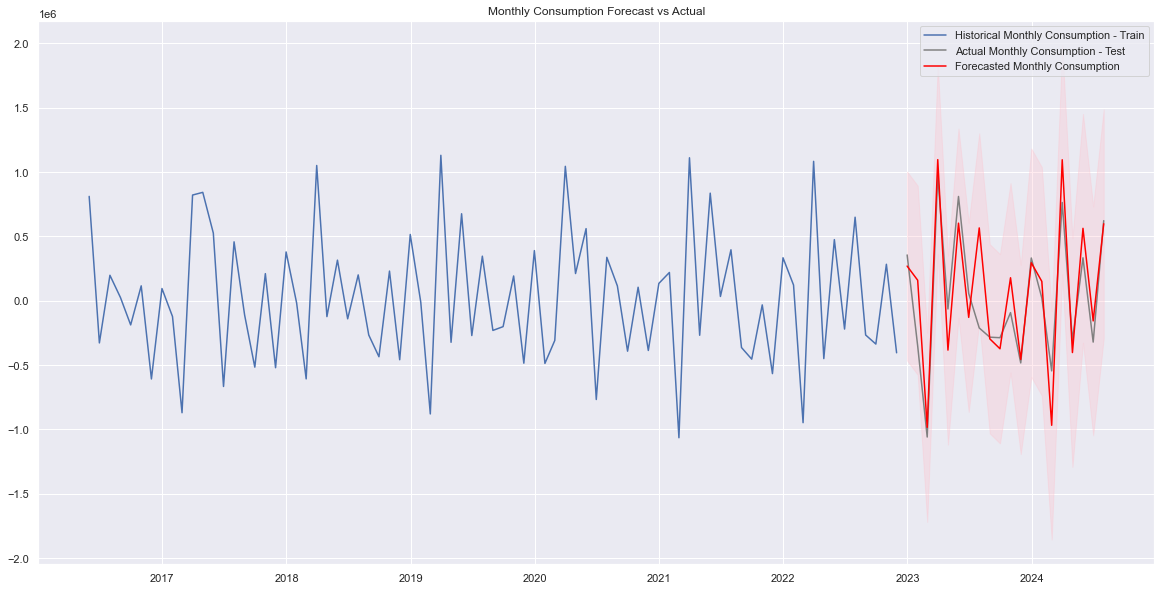

MAE: 205624.39294402133
MAPE: 131.75361920174703 %
RMSE:  278480.55599132786


In [29]:
# Forecast the same number of steps as in the test set
forecast = results.get_forecast(steps=len(df_test))
forecast_ci = forecast.conf_int()

# Plot the forecast along with the historical data
plt.figure(figsize=(20, 10))
plt.plot(df_train.index, df_train, label='Historical Monthly Consumption - Train')
plt.plot(df_test.index, df_test, label='Actual Monthly Consumption - Test', color='gray')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecasted Monthly Consumption', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Monthly Consumption Forecast vs Actual')
plt.legend()
plt.show()

# Evaluate the forecast
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt


# Calculate MAE
mae = mean_absolute_error(df_test, forecast.predicted_mean)
print('MAE:', mae)

# Calculate MAPE
mape = np.mean(np.abs((df_test - forecast.predicted_mean) / df_test)) * 100
print('MAPE:', mape, '%')

rmse = sqrt(mean_squared_error(df_test, forecast.predicted_mean))
print('RMSE: ', rmse)